In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import binascii
from scipy.io import wavfile

In [2]:
noiseRate, noise = wavfile.read("interference.wav")
print("noise rate", noiseRate)
IPython.display.Audio(noise, rate=noiseRate)

noise rate 8192


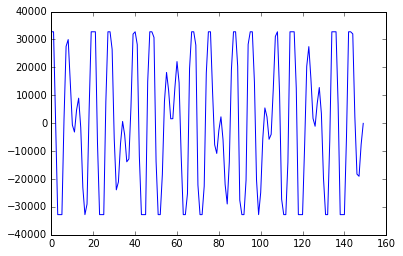

In [3]:
plt.plot(noise[0:150])
plt.show()

In [4]:
noiseF = np.fft.fft(noise)

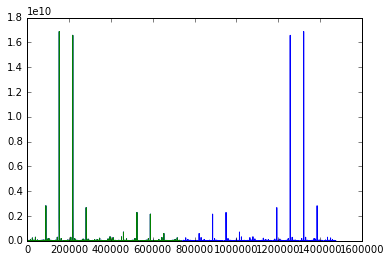

In [5]:
plt.plot(np.abs(noiseF))
plt.plot(np.abs(noiseF[0:int(len(noiseF)/2)]))
plt.show()

In [6]:
noiseMean = np.mean(noise)
noiseVar = np.var(noise)
print("noise mean", noiseMean)
print("noise var", noiseVar)

noise mean -0.326777257774
noise var 575624720.495


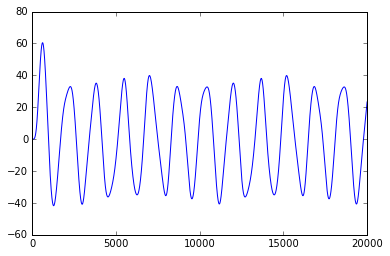

In [7]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff = 10
order = 6

b, a = butter_lowpass(cutoff, noiseRate, order)
y = lfilter(b, a, noise)
plt.plot(y[0:20000])
plt.show()

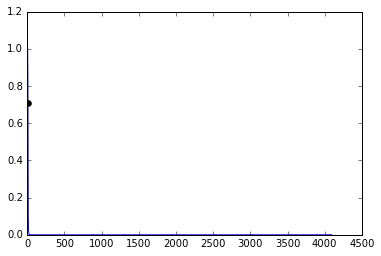

In [8]:
b, a = butter_lowpass(cutoff, noiseRate, order)
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*noiseRate*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.show()

In [9]:
def toBin(text):
    return list(int(b) for b in bin(int.from_bytes(text.encode(), 'big'))[2:])

def toStr(arr):
    i = int("".join(str(c) for c in arr), 2)
    return i.to_bytes((i.bit_length() + 7) // 8, 'big').decode()

text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut eros augue, tincidunt mollis urna at, molestie malesuada elit."
assert toStr(toBin(text)) == text
bintext = toBin(text)

In [10]:
def code(bintext, codebook):
    return [codebook[b] for b in bintext]

def space(signal, num):
    y = np.zeros(len(signal) * num)
    y[np.arange(len(signal)) * num] = signal
    return y

In [11]:
codetext = code(bintext, {
    0: -1,
    1: 1
})
codetext[0:20]

[1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1]

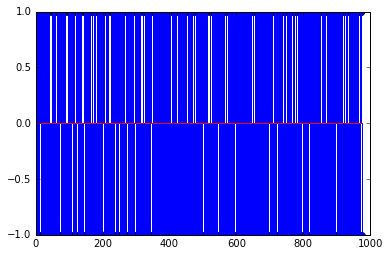

In [12]:
code = codetext
#code = codetext[0:10]
plt.stem(code)
plt.show()

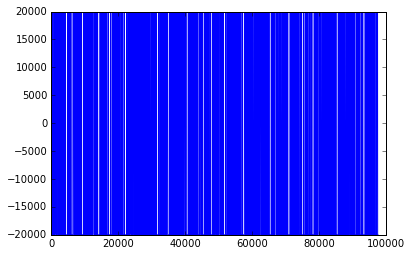

In [13]:
step = 100
amplitude = 20000
signal = space(code, step)
h = np.multiply(np.ones(step), amplitude)
x = np.convolve(signal, h)[:-step+1]
plt.plot(x)
plt.show()

In [14]:
IPython.display.Audio(x, rate=noiseRate)

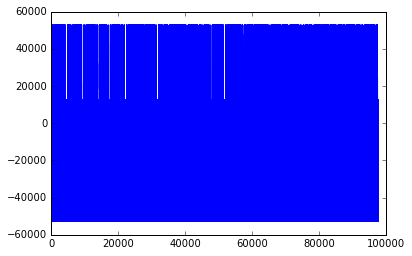

In [15]:
channel = x + noise[:len(x)]
plt.plot(channel)
plt.show()

In [16]:
IPython.display.Audio(channel, rate=noiseRate)

In [17]:
def sample(signal, num):
    return signal[np.arange(0, len(signal), num)]

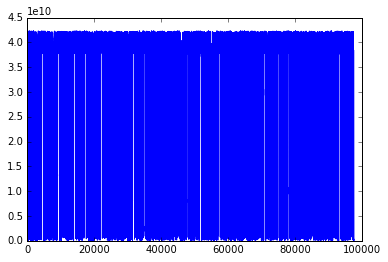

In [18]:
matched = np.convolve(channel, h[::-1])
plt.plot(abs(matched))
plt.show()

def matcher(signal, h, step, decision):
    matched = np.convolve(signal, h[::-1])
    sampled = matched[np.arange(0, len(matched), step)]
    return [decision(s) for s in sampled]

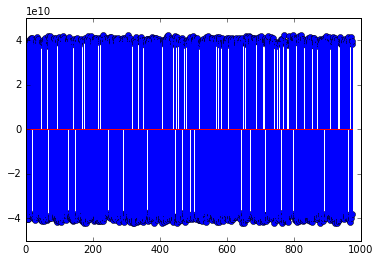

In [19]:
sampled = sample(matched, step)
plt.stem(sampled)
plt.show()

In [20]:
decided = matcher(signal, h, step, lambda x: 0 if x < 0 else 1)

In [21]:
for i in range(0, len(decided) - 1):
    if decided[i] != bintext[i]:
        print(decided[i], "was not", bintext[i])

print(toStr(decided[:-1]))
print(text)

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut eros augue, tincidunt mollis urna at, molestie malesuada elit.
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut eros augue, tincidunt mollis urna at, molestie malesuada elit.


In [22]:
recRate, rec = wavfile.read("output2.wav")
print("noise rate", recRate)
IPython.display.Audio(rec, rate=recRate)

FileNotFoundError: [Errno 2] No such file or directory: 'output2.wav'

In [ ]:
plt.plot(rec)
plt.show()

In [ ]:
plt.plot(rec[15000:])
plt.show()

In [ ]:
dec = matcher(rec[15000:], h, step, lambda x: 0 if x < 0 else 1)

dec = [1-x for x in dec]

for i in range(0, len(dec) - 1):
    if dec[i] != bintext[i]:
        print(dec[i], "was not", bintext[i])

print(toStr(dec[:-1]))
print(text)